In [8]:
import sys, os, glob, random, copy, time, shutil, re
import itertools
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
# random.seed(666)
from collections import Counter
import numpy as np
from itertools import cycle
import pandas as pd
import seaborn as sns
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))  # Expand the palette
from matplotlib import pyplot
from scipy.stats import norm
from numpy import linspace
from pylab import plot,show,hist,figure,title
import matplotlib.pylab as plt
import jellyfish
try:
    def hamming_distance(s1, s2):
        if s1 == s2:
            return 0
        else:
            return jellyfish.hamming_distance(s1, s2)
    assert(hamming_distance('ABC', 'ABCD') == 1)
except:
    def hamming_distance(s1, s2):
        if s1 == s2:
            return 0
        else:
            return jellyfish.hamming_distance(unicode(s1), unicode(s2))
    assert(hamming_distance('ABC', 'ABCD') == 1)

import traceback
class nostdout(object):
    def __enter__(self):
        self.stdout = sys.stdout
        sys.stdout = self
    def __exit__(self, type, value, traceback):
        sys.stdout = self.stdout
        if type is not None:
            raise
    def write(self, x): pass

In [9]:
def plot_AAseq_CDF(df, verbose=True):
    plot_dir_CDF = plot_dir+'/AAseq_CDF'
    if not os.path.exists(plot_dir_CDF):
        os.makedirs(plot_dir_CDF)

    def AUC(res, locus, st, cut):
        try:
            counts = Counter(res[locus][st])
            hd = [k for k, v in counts.items() if k <= cut]
            c = [v for k, v in counts.items() if k <= cut]
            hd, c = zip(*sorted(zip(hd, c)))
            acc = [sum(c[0:i]) + c[i] for i in range(len(c))]
            sc = sum(v for k, v in counts.items())
            auc = sum(acc[i]*(hd[i+1]-hd[i]) for i in range(len(hd)-1)) / sc
            return(auc)
        except:
            return(0)
    

    def CDF_plot(res, xlimit, pnam):
        # %matplotlib inline
        from matplotlib.backends.backend_pdf import PdfPages
        pp = PdfPages(pnam)
        for locus in res:
            fig, ax = pyplot.subplots(figsize=(14,10))
            for st in res[locus]:
                if st[0][0:3] == '3FT' and st[1][0:3] == '3FT':
                    color = 'green'
                elif st[0][0:3] == 'PLA' and st[1][0:3] == 'PLA':
                    color = 'blue'
                else:
                    color = 'red'
                auc = AUC(res, locus, st, xlimit)
                ax = sns.distplot(
                    res[locus][st],
                    label='{} vs. {} AUC {:.1f}'.format(st[0], st[1], auc),
                    color=color,
                    kde=False,
                    bins=list(range(0, 1000)),
                    norm_hist=True,  # On/off to normalize y-axis
                    hist_kws={'histtype':'step', 'cumulative':True, 'lw':3}
                )
                lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                ax.set_title('Locus: {}'.format(locus))
                ax.set_xlim(0, xlimit)
                ax.set(xlabel='Hamming distance', ylabel='Fraction overlap')
            fig.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
        pp.close()


    def compare_AAseq(table, trim=0, downsample=False, weighted=False, mode='naiveAA'):
        hamming_dist_xlimit = 10 if mode == 'Fcdr3' else 30
        df = table.copy(deep=True)
        # Trim out small clonal families:
        df = df[df['Nseqs'] > trim]

        row_part = dict()
        dist_table = dict()

        samples = list(set(df['sample']))
        loci = set(df['locus'])

        if downsample:
            for locus in loci:
####
#                if locus != 'IgH':
#                    continue
                smallest = 9999999999
                for sample in samples:
                    print(len(df[(df['locus'] == locus) & (df['sample'] == sample)]))
                    size = sum(np.array(df['locus'] == locus) & np.array(df['sample'] == sample))
                    if size < smallest:
                        smallest = size
                print('Downsampling to:', smallest)
                for sample in samples:
                    # Finding the downsample:
                    ds = df[(df['locus'] == locus) & (df['sample'] == sample)].sample(smallest, replace=False)
                    # Dropping all columns:
                    df = df[np.invert(np.array(((df['locus'] == locus) & (df['sample'] == sample))))]
                    # Adding the downsample:
                    df = df.append(ds)
        v_grps = set(df['v_grp'])
        d_grps = set(df['d_grp'])
        j_grps = set(df['j_grp'])
        vdj_len = set(df['vdj_len'])


        for index, row in df.iterrows():
            # kt = (row['locus'], row['v_grp'], row['d_grp'], row['j_grp'], row['vdj_len'])
            kt = (row['locus'], row['v_grp'], row['d_grp'], row['j_grp'])
            if kt not in row_part:
                row_part[kt] = [index]
            else:
                row_part[kt].append(index)
        sumstat = [len(l) for l in row_part.values()]
        #    print('These are the number of entries in each partition:', list(map(str, sumstat)))

        # res[locus][s1:s2] = [dist, 5, 2, 0,...]
        res = dict()
        for locus in loci:
####
#            if locus != 'IgH':
#                continue
            res[locus] = dict()
            for i in range(len(samples)):
                for j in range(i+1, len(samples)):
                    si = samples[i]
                    sj = samples[j]
                    res[locus][(si, sj)] = list()
                    for kt, li in row_part.items():
                        if locus != kt[0]:
                            continue
                        if mode == 'naiveAA':
                            seqi = list(df.loc[li][df.loc[li]['sample'] == si]['naiveAA'])
                            seqj = list(df.loc[li][df.loc[li]['sample'] == sj]['naiveAA'])
                        elif mode == 'Fseq':
                            seqi = [Counter(i.split(':')).most_common()[0][0] for i in df.loc[li][df.loc[li]['sample'] == si]['input_seqsAA']]
                            seqj = [Counter(i.split(':')).most_common()[0][0] for i in df.loc[li][df.loc[li]['sample'] == sj]['input_seqsAA']]
                        elif mode == 'Fcdr3':
                            seqi = [Counter([str(Seq(s[int(b):int(e)], generic_dna).translate()) for s in i.split(':')]).most_common()[0][0] for i, b, e in zip(df.loc[li][df.loc[li]['sample'] == si]['input_seqs'], df.loc[li][df.loc[li]['sample'] == si]['CDR3_start'], df.loc[li][df.loc[li]['sample'] == si]['CDR3_end'])]
                            seqj = [Counter([str(Seq(s[int(b):int(e)], generic_dna).translate()) for s in i.split(':')]).most_common()[0][0] for i, b, e in zip(df.loc[li][df.loc[li]['sample'] == sj]['input_seqs'], df.loc[li][df.loc[li]['sample'] == sj]['CDR3_start'], df.loc[li][df.loc[li]['sample'] == sj]['CDR3_end'])]
                        else:
                            raise BaseException('mode not supported')
                        if len(seqi) == 0 or len(seqj) == 0:
                            continue
                        hdj = [min(hamming_distance(ni, nj) for ni in seqi) for nj in seqj]
                        hdi = [min(hamming_distance(ni, nj) for nj in seqj) for ni in seqi]
                        if weighted is True:
                            cf_abui = list(df.loc[li][df.loc[li]['sample'] == si]['total_abundance'])
                            cf_abuj = list(df.loc[li][df.loc[li]['sample'] == sj]['total_abundance'])
                            hdj = [h for h, a in zip(hdj, cf_abuj) for i in range(a)]
                            hdi = [h for h, a in zip(hdi, cf_abui) for i in range(a)]
                        res[locus][(si, sj)].extend(hdi)
                        res[locus][(si, sj)].extend(hdj)

        ds = '_downsampled' if downsample else ''
        we = '_weighted' if weighted else ''
        pnam = plot_dir_CDF + '/{}_comparison_trim{}{}{}.pdf'.format(mode, trim, ds, we)
        CDF_plot(res, hamming_dist_xlimit, pnam)


    trim_list = [0, 5]
    # downsample_list = [True, False]
    downsample_list = [True]
    # weighted_list = [True, False]
    weighted_list = [True]
    mode = ['naiveAA', 'Fseq', 'Fcdr3']
    combs = list(itertools.product(*[trim_list, downsample_list, weighted_list, mode]))
    for c in combs:
        if verbose:
            compare_AAseq(df, *c)
        else:
            with nostdout():
                compare_AAseq(df, *c)

In [10]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [11]:
def plot_annotation_distributions(df, verbose=False):
    pass
    
    

In [12]:
color = color=sns.light_palette("purple")[3]
color_list = sns.color_palette('Blues', n_colors=3) + sns.diverging_palette(10, 220, sep=80, n=7)[0:2]
sample_list = ['3FTx-1', '3FTx-2', '3FTx-3', 'PLA2-1', 'PLA2-2']
sample2color = dict(zip(sample_list, color_list))

In [13]:
def lengh_dist(locus='IgH', mode='CDR3_len', normalizer='clonal family', seaborn=False, min_observations_pct=0.1):
    %matplotlib inline

    ### Data prep.:
    df_l = df[df['locus'] == locus]
    locus_row_count = len(df_l)
    df_l['CDR3_len'] = ((df_l['CDR3_end'] - df_l['CDR3_start'])/3).astype(int)

    if normalizer == 'clonal family':
        data_slice = {'sample': df_l['sample'].values,
                      mode: df_l[mode].values}
    elif normalizer == 'Nseqs':
        data_slice = {'sample': np.array([val for val, mult in zip(df_l['sample'], df_l['Nseqs']) for i in range(mult)]),
                      mode: np.array([val for val, mult in zip(df_l[mode], df_l['Nseqs']) for i in range(mult)])}
    else:
        raise BaseException('Normalizer not supported')
    df_l = pd.DataFrame(data=data_slice, columns=['sample', mode])
    
    cut = min_observations_pct*locus_row_count/100
    gc = df_l[mode].value_counts()
    min_c  = list(gc[gc>cut].index)
    df_l = df_l.loc[df_l[mode].isin(min_c)]
    ###

    ### Plot aesthetics:
    fig, ax = pyplot.subplots(figsize=(14,10))
    title('{} distribution (aggregate histogram and sample wise normal fit)'.format(mode))
    ax.grid(False)
    ax.grid(True, axis='y')
    _ = plt.xticks(rotation=30)
    padding = 2
    ### 


    ### seaborn hist (no sample comparison):
    if seaborn is True:
        ax = sns.barplot(x=mode,
                         y=mode,
                         data=df_l,
                         estimator=lambda x: len(x) / locus_row_count,
                         color=color)
    else:
    ### matplotlib hist with sample comparison:
        ax.set_xlim(df_l[mode].values.min()-padding, df_l[mode].values.max()+padding)

        samp = df_l[mode].values
        x = linspace(min(samp)-padding, max(samp)+padding, 300)
        for sample, col in sample2color.items():
            param = norm.fit(df_l[df_l['sample'] == sample][mode].values)
            pdf_fitted = norm.pdf(x, *param)
            plot(x, pdf_fitted, color=col, label=sample)
        hist(samp, normed=1, alpha=.5, bins=sorted(list(set(samp))), ec='black')

        pyplot.legend()


    ### Plot aesthetics:
    ax.set(xlabel='{} (amino acids)'.format(mode), ylabel='Fraction of {}'.format(normalizer))
    ###

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


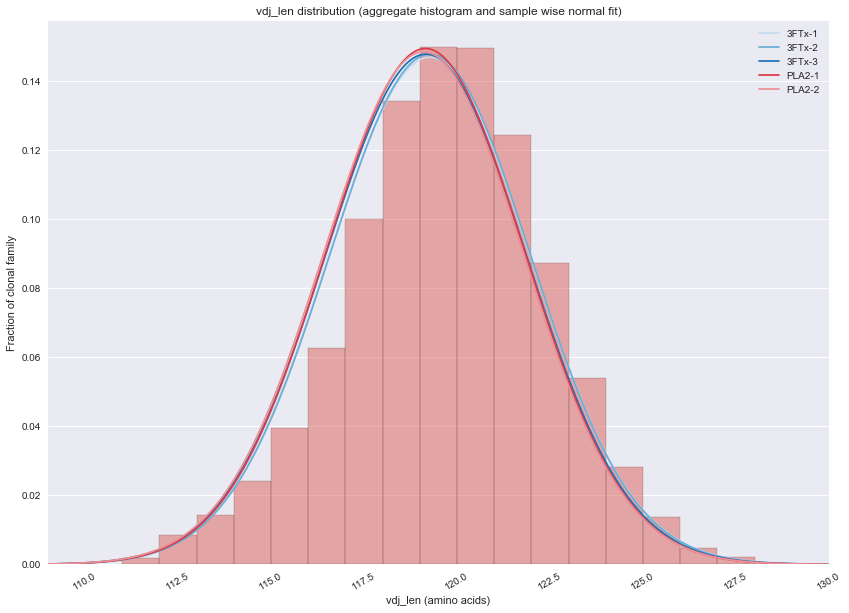

In [14]:
lengh_dist(locus='IgH', mode='vdj_len', normalizer='clonal family', seaborn=False, min_observations_pct=0.05)

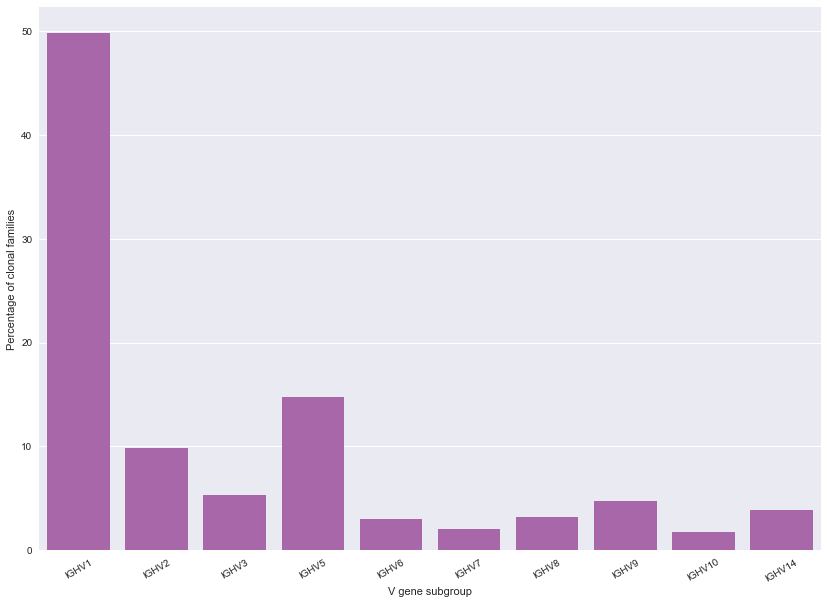

In [15]:
%matplotlib inline
locus = 'IgH'
gene = 'v'
min_observations_pct = 1
df_l = df[df['locus'] == locus]
locus_row_count = len(df_l)
cut = min_observations_pct*locus_row_count/100
gc = df['{}_grp'.format(gene)].value_counts()
min_c  = list(gc[gc>cut].index)
df_l = df_l.loc[df_l['{}_grp'.format(gene)].isin(min_c)]
fig, ax = pyplot.subplots(figsize=(14,10))
ax = sns.barplot(x='{}_grp'.format(gene),
                 y='{}_grp'.format(gene),
                 color=color,
                 orient='v',
                 order=sorted(list(set(df_l['{}_grp'.format(gene)])), key=natural_keys),
                 estimator=lambda x: len(x) / locus_row_count * 100,
                 data=df_l
                  )
ax.set(xlabel='V gene subgroup', ylabel='Percentage of clonal families')
_ = plt.xticks(rotation=30)

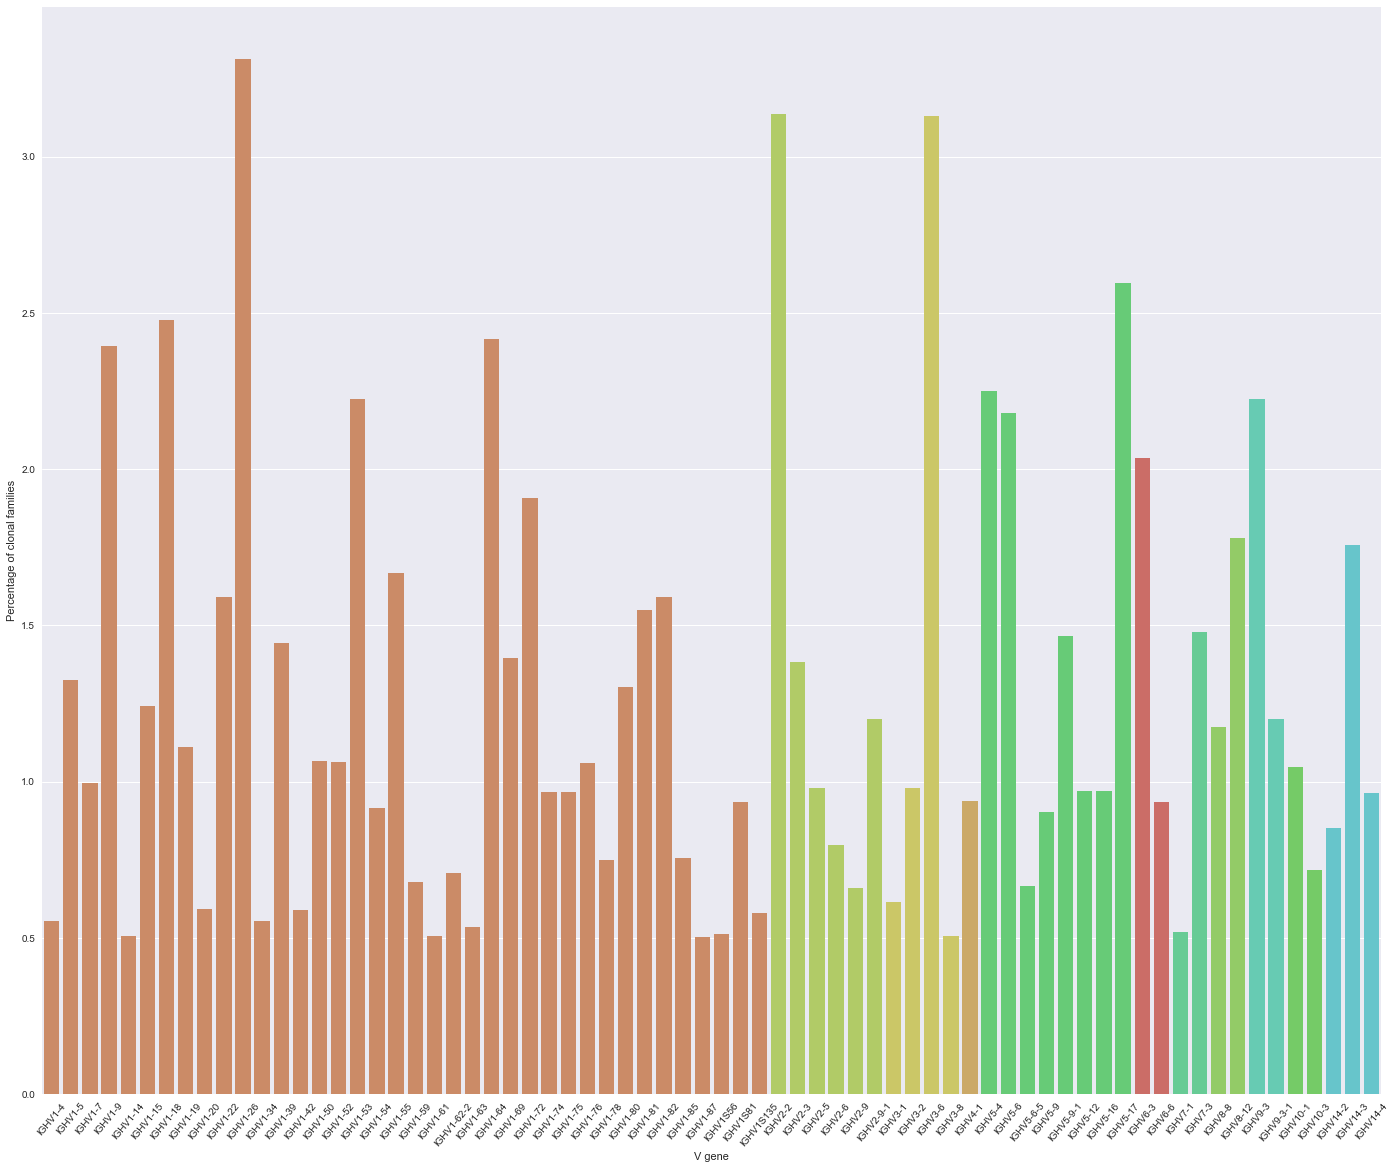

In [16]:
import matplotlib.pylab as plt
locus = 'IgH'
gene = 'v'
min_observations_pct = 0.5
df_l = df[df['locus'] == locus]
locus_row_count = len(df_l)
cut = min_observations_pct*locus_row_count/100
gc = df['{}_gene'.format(gene)].value_counts()
min_c  = list(gc[gc>cut].index)
df_l = df_l.loc[df_l['{}_gene'.format(gene)].isin(min_c)]
### Color palette:
color_labels = df_l['{}_grp'.format(gene)].unique()
# List of RGB triplets
# rgb_values = sns.color_palette("Set2", len(color_labels))
rgb_values = sns.color_palette(n_colors=len(color_labels))
# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))
color_list = df_l['{}_grp'.format(gene)].map(color_map)
color_dict = {g:c for c, g in zip(color_list, df_l['{}_gene'.format(gene)])}
###
fig, ax = pyplot.subplots(figsize=(24,20))
ax = sns.barplot(x='{}_gene'.format(gene),
                 y='{}_gene'.format(gene),
                 orient='v',
                 estimator=lambda x: len(x) / locus_row_count * 100,
                   palette=color_dict,
                   order=sorted(list(set(df_l['{}_gene'.format(gene)])), key=natural_keys),
                   data=df_l
                  )
ax.set(xlabel='V gene', ylabel='Percentage of clonal families')
_ = plt.xticks(rotation=50)

In [17]:
def gene_dist(locus='IgH', mode='grp', genes=['v', 'j'], normalizer='clonal family', min_observations_pct=1):
    %matplotlib inline

    df_l = df[df['locus'] == locus]
    locus_row_count = len(df_l)

    if normalizer == 'clonal family':
        count_list = [1] * locus_row_count
    elif normalizer == 'Nseqs':
        count_list = df_l['Nseqs']
    else:
        raise BaseException('Normalizer not supported')

    if len(genes) == 2:
        df_gene = pd.DataFrame(data=list(zip(*[list(df_l['sample'].values),
                                         list((df_l['{}_{}'.format(genes[0], mode)] + '-' + df_l['{}_{}'.format(genes[1], mode)]).values),
                                         count_list])),
                         columns=['sample', 'gene', 'count'])
    elif len(genes) == 1:
        df_gene = pd.DataFrame(data=list(zip(*[list(df_l['sample'].values),
                                         list(df_l['{}_{}'.format(genes[0], mode)].values),
                                         count_list])),
                         columns=['sample', 'gene', 'count'])
    else:
        raise BaseException('genes wrongly specified')

    vj_counts = df_gene.groupby(['sample', 'gene']).sum()
    vj_counts.reset_index(level=['sample', 'gene'], inplace=True)

    sample_counts = df_gene.groupby(['sample']).sum()
    sample_counts.reset_index(level=['sample'], inplace=True)

    gene_count = 100 * df_gene.groupby(['gene']).sum() / sum(df_gene.groupby(['gene']).sum().values)
    gene_count.reset_index(level=['gene'], inplace=True)
    gene_count = gene_count[gene_count['count']>min_observations_pct]
    keep_gene = set(gene_count['gene'])
    # Insert 0 observations for genes kept with no observations for some sample:
    for kg in keep_gene:
        for s in sample_list:
            l = vj_counts.loc[vj_counts['sample'].isin([s]) & vj_counts['gene'].isin([kg])]
            if len(l) == 0:
                vj_counts = vj_counts.append(pd.DataFrame([[s, kg, 0]], columns=list(vj_counts.columns)))
    sc_dict = dict(zip(sample_counts['sample'], sample_counts['count']))
    vj_counts['percentage'] = 100 * vj_counts['count'] / vj_counts['sample'].map(sc_dict)

    fig, ax = pyplot.subplots(figsize=(24,20))
    sns.pointplot(x='gene',
                  y='percentage',
                  hue='sample',
                  order=sorted(list(keep_gene), key=natural_keys),
                  palette=sample2color,
                  data=vj_counts
                 )
    if len(genes) == 2:
        ax.set(xlabel='{}-{} {}'.format(genes[0], genes[1], mode), ylabel='Percentage of {}'.format(normalizer))
    elif len(genes) == 1:
        ax.set(xlabel='{} {}'.format(genes[0], mode), ylabel='Percentage of {}'.format(normalizer))
    _ = plt.xticks(rotation=30)

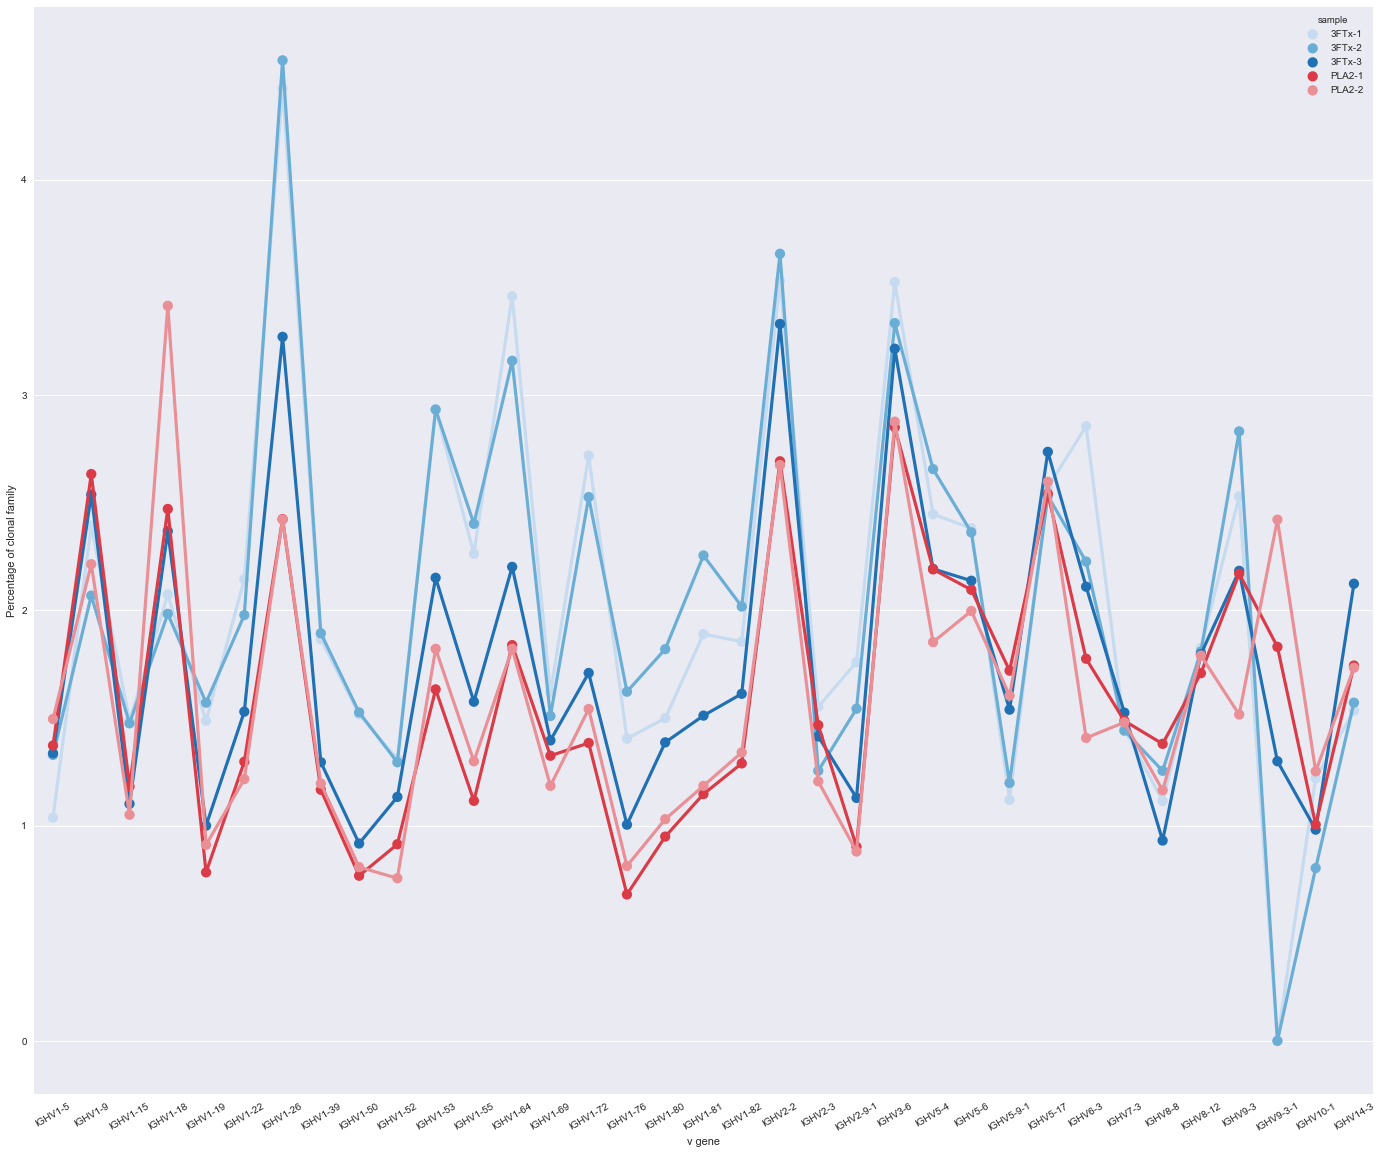

In [18]:
gene_dist(locus='IgH', mode='gene', genes=['v'], normalizer='clonal family', min_observations_pct=1)

In [7]:
data_dir = 'data2'
plot_dir = 'plots2'
#df = pd.read_pickle(data_dir+'/cf.pickle')
df = pd.read_pickle(data_dir+'/cf_master.pickle')
#df = df.sample(n=1000)

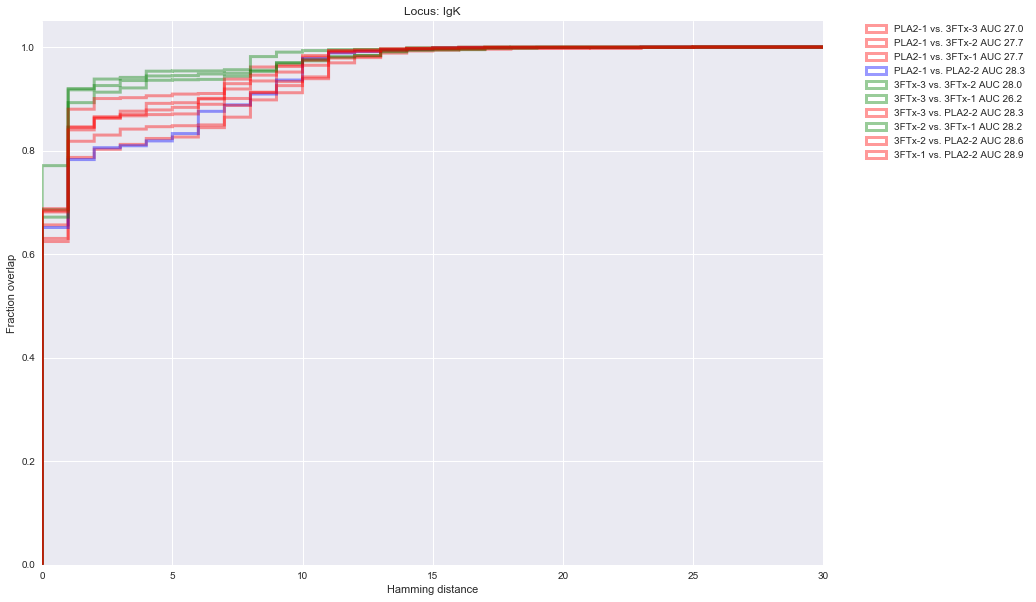

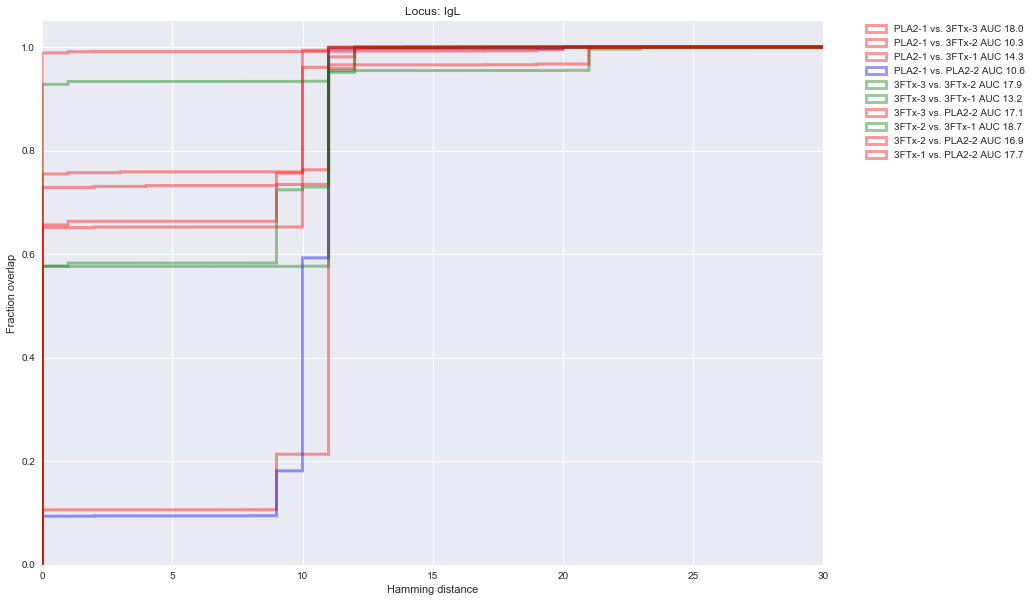

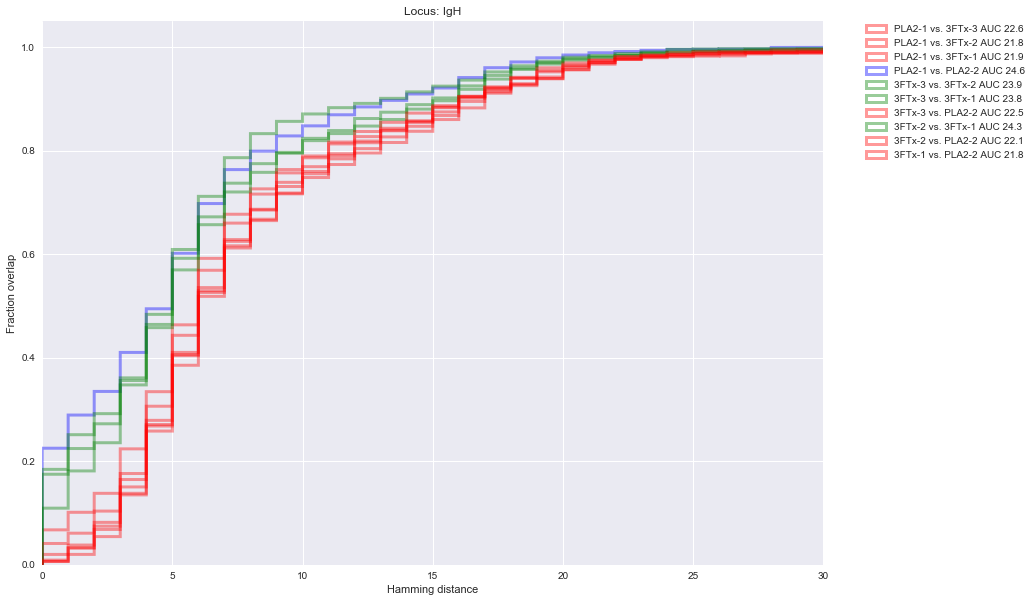

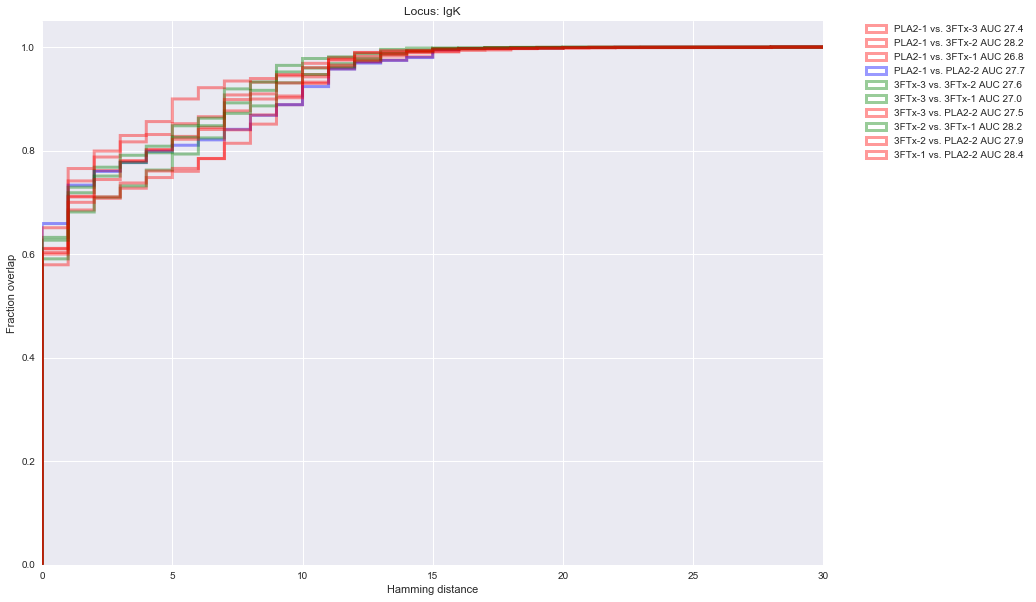

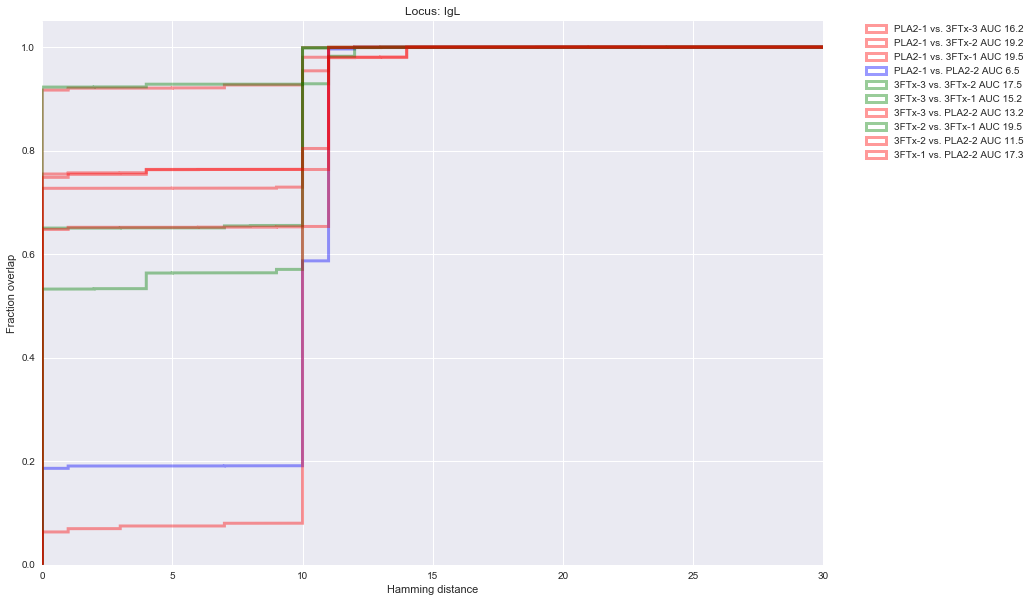

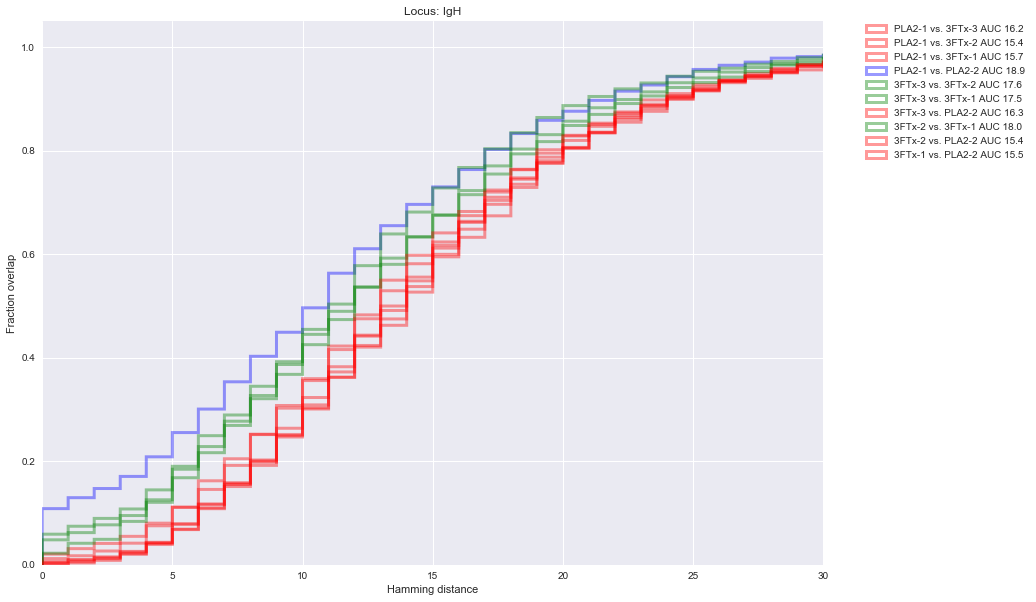

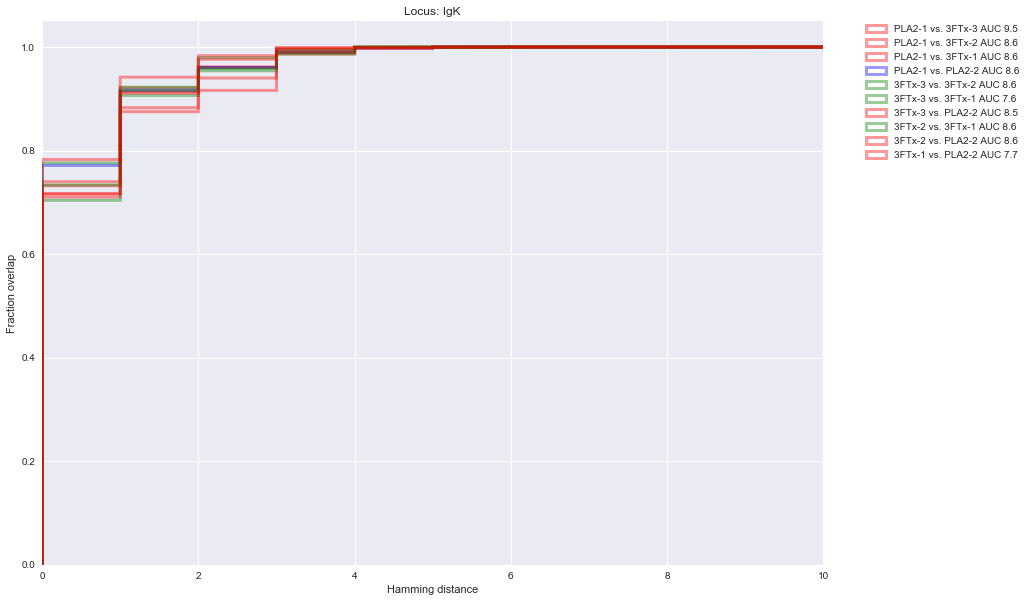

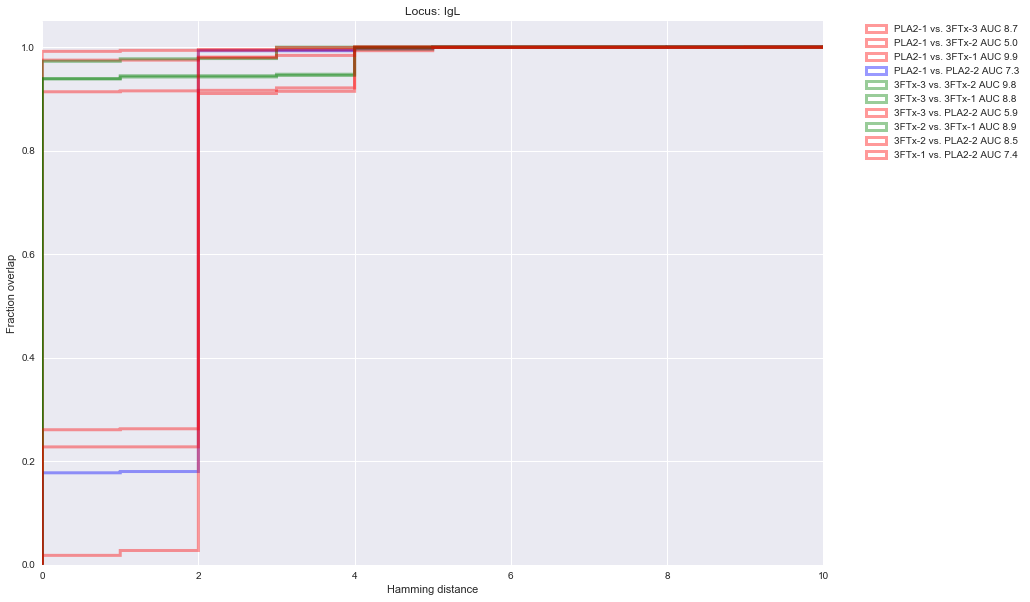

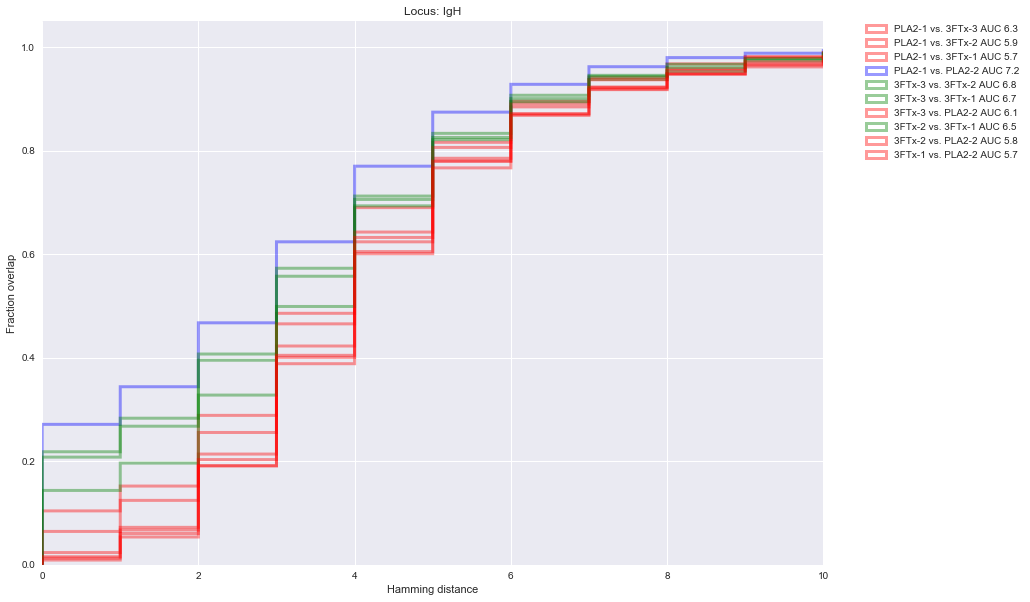

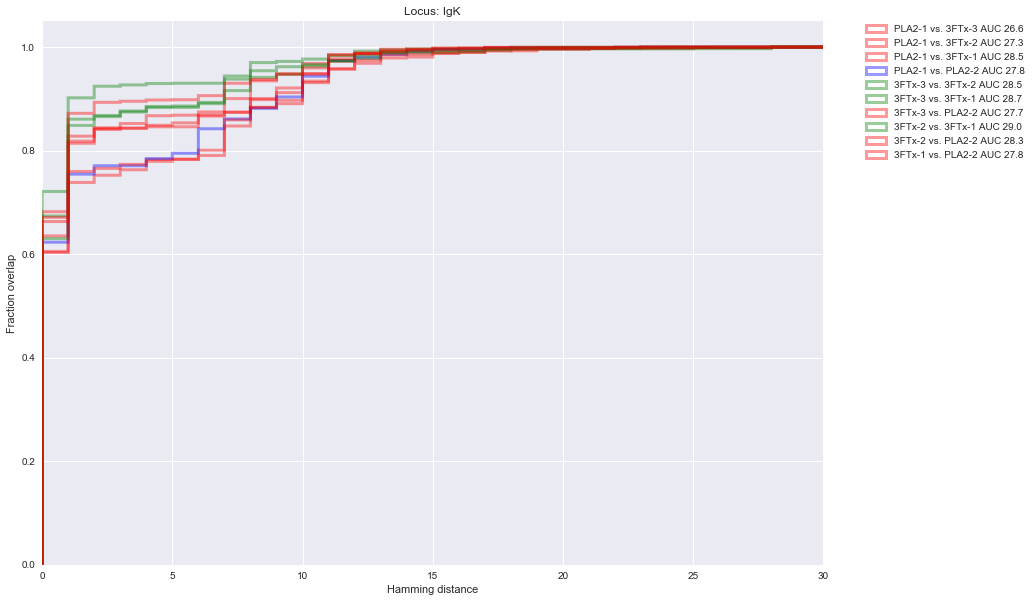

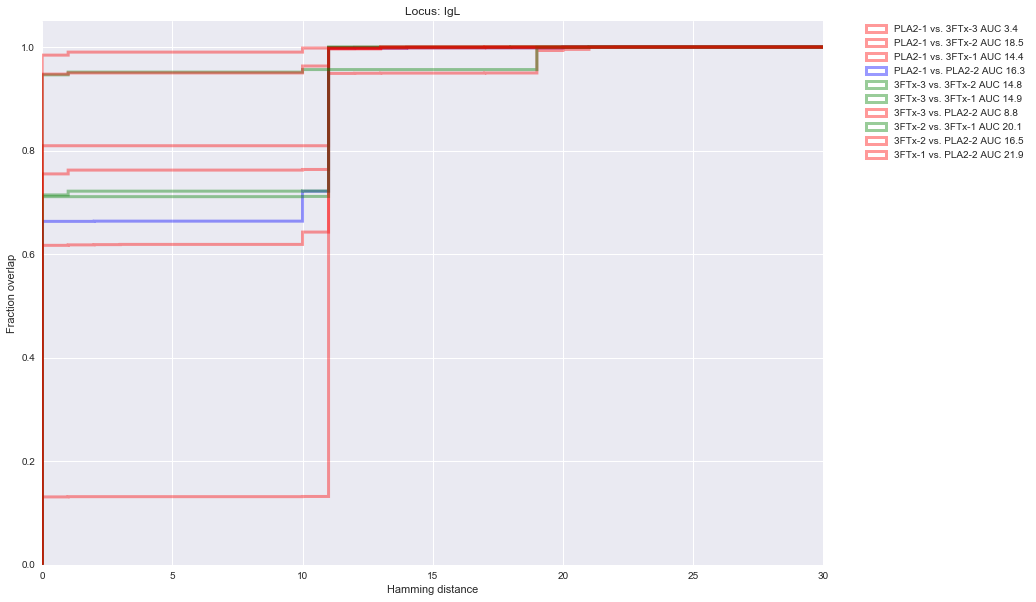

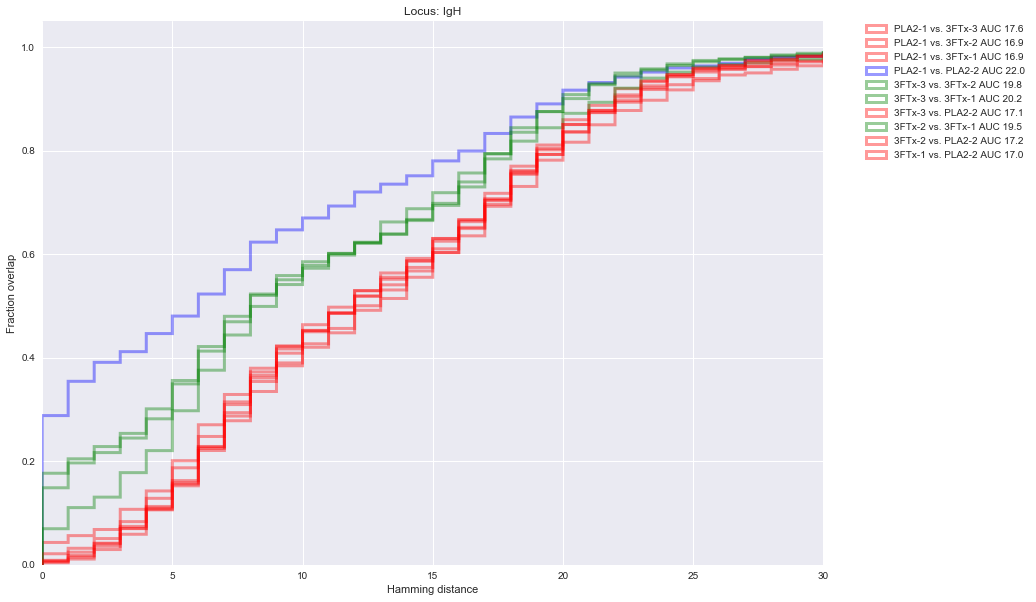

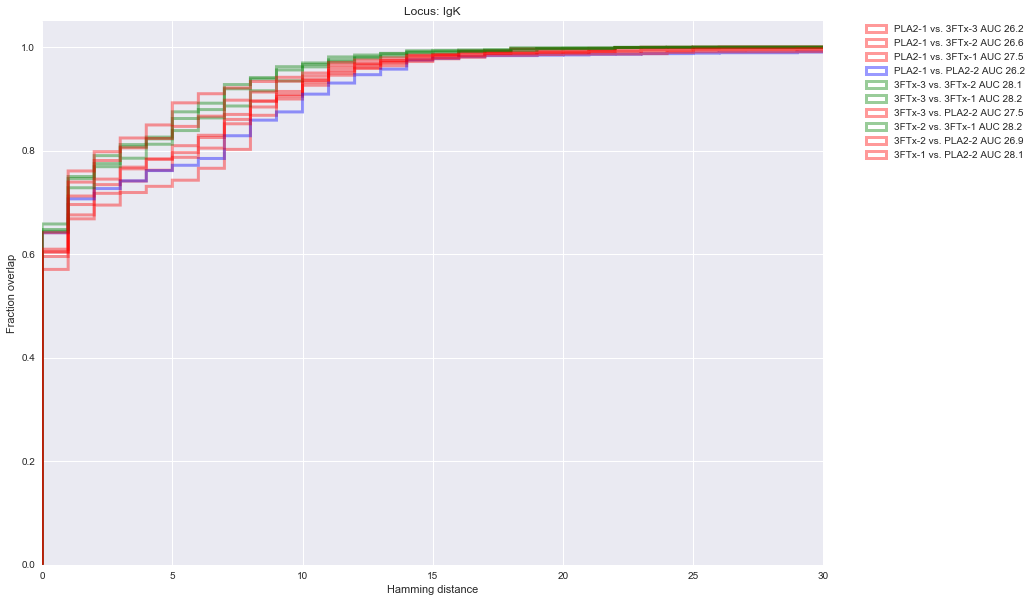

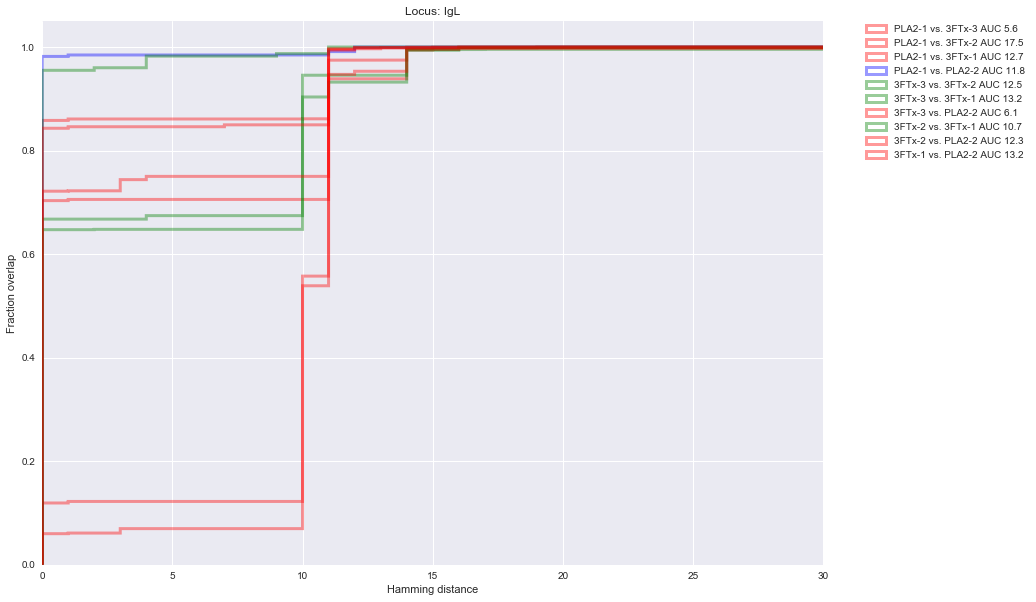

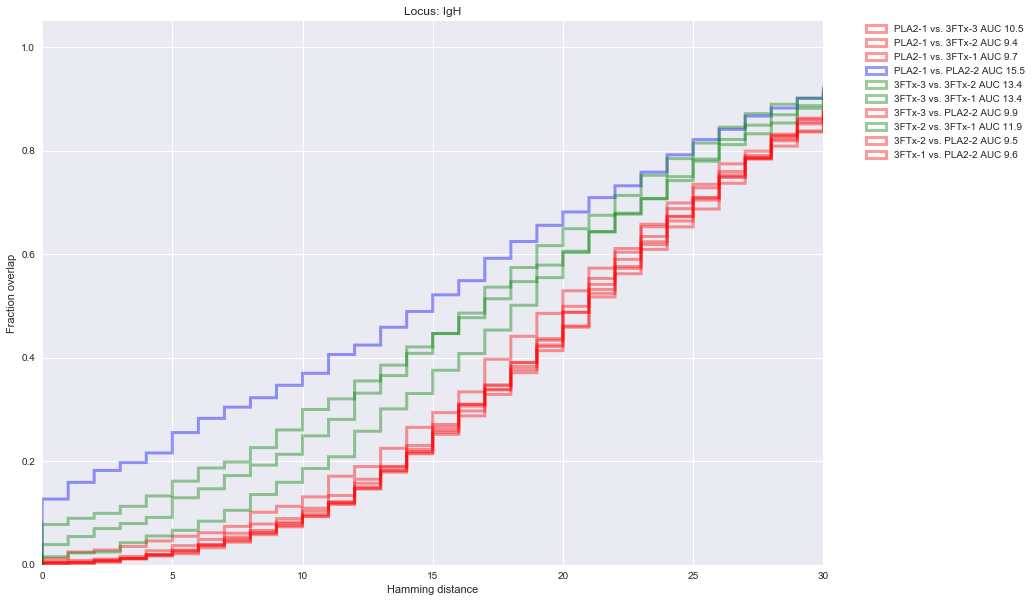

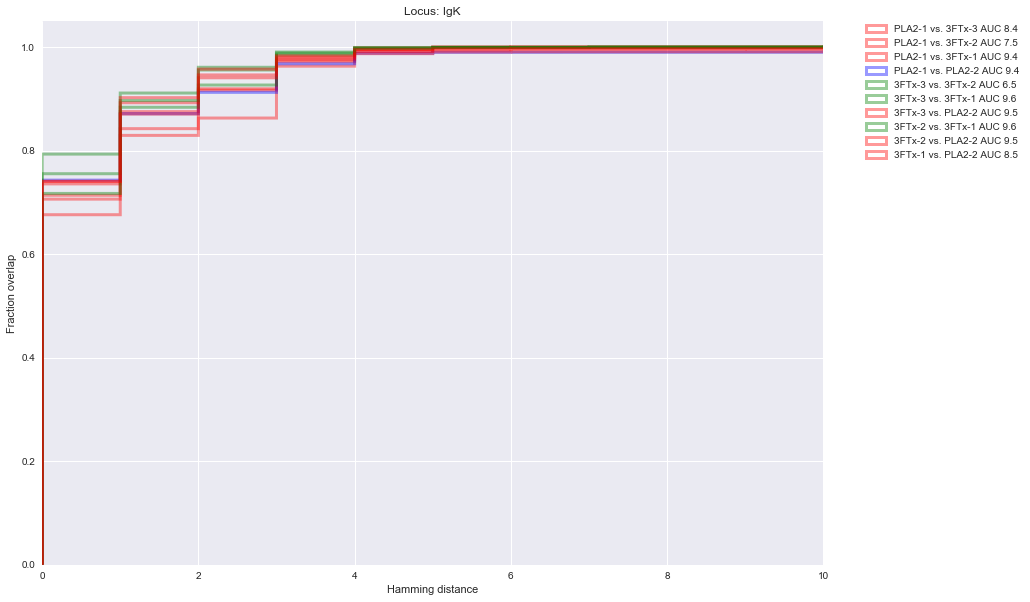

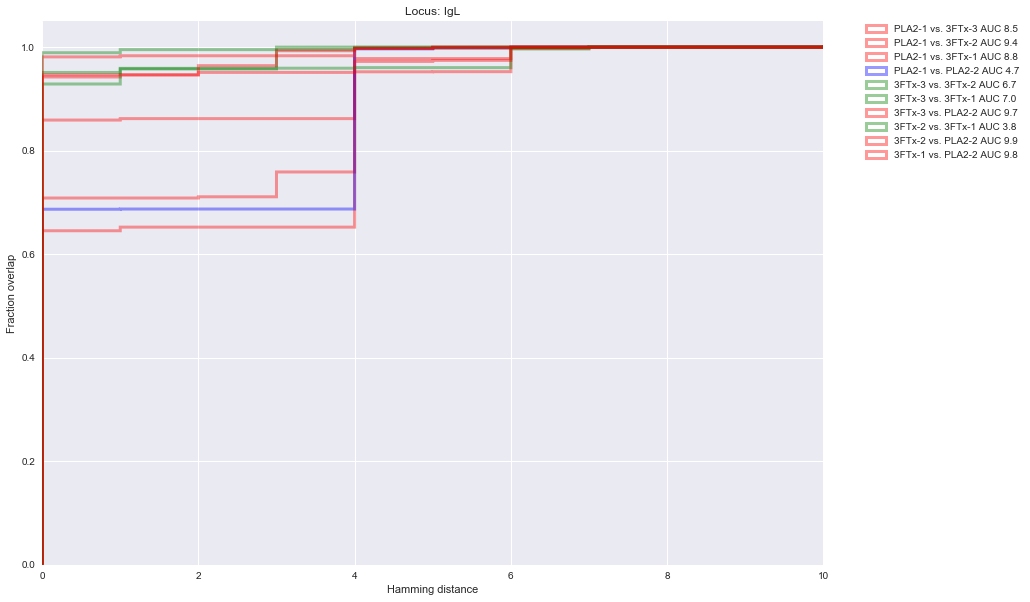

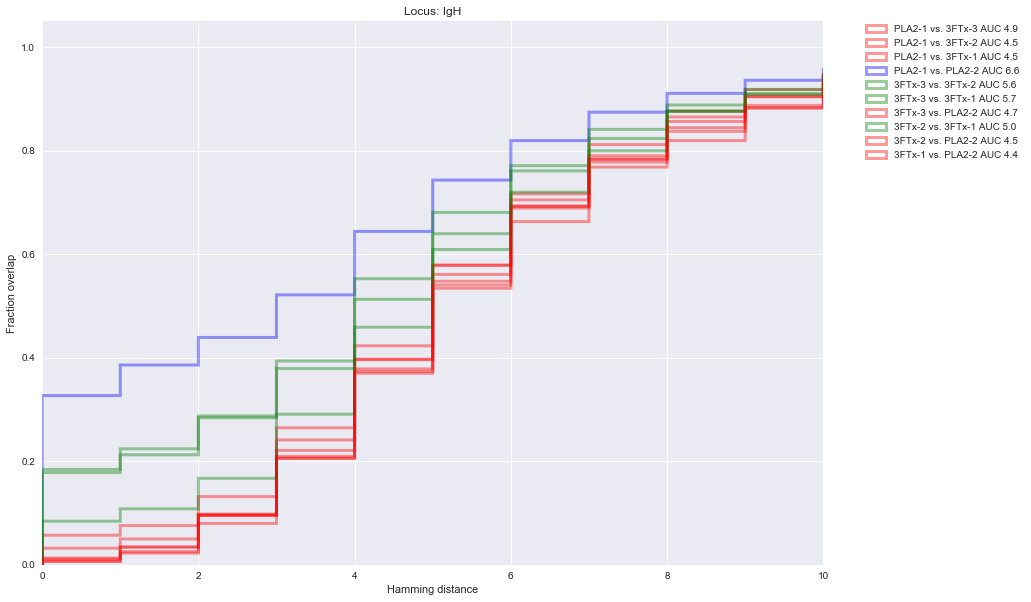

In [19]:
### Placeholder for all the plotting functions:
plot_AAseq_CDF(df, verbose=False)

In [ ]:
plot_annotation_distributions(df, verbose=False)